In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import mpl_toolkits
from mpl_toolkits import mplot3d
import rosbag
import glob
from urdf_parser_py.urdf import URDF
from pykdl_utils.kdl_parser import kdl_tree_from_urdf_model
from pykdl_utils.kdl_kinematics import KDLKinematics
import time
from IPython import display

from numpy import linalg
from mpl_toolkits.mplot3d import Axes3D

from matplotlib import cm
#%matplotlib qt
import matplotlib.colors as colors
import random

In [2]:
data_path = './Robot_ViconNovember/'

In [3]:
## Load Vicon data and store in np file
vicobags_dyna = glob.glob(data_path+'VD/*.bag')
for i,bag in enumerate(vicobags_dyna): # loop over vicon bags
    vdbag = rosbag.Bag(bag)
    vicon_dynaXpos = []
    vicon_dynaYpos = []
    vicon_dynaZpos = []
    viconbag_time_dyna = []
    for topicc, msgg, tt in vdbag.read_messages(topics=['/vicon/PEE/PEE']): # extract data
        vicon_dynaXpos.append(msgg.transform.translation.x)
        vicon_dynaYpos.append(msgg.transform.translation.y)
        vicon_dynaZpos.append(msgg.transform.translation.z) 
        vicon_time_dy = tt.secs
        viconbag_time_dyna.append(vicon_time_dy)
    vdbag.close()

    vicon_dynaXPosArr = np.array(vicon_dynaXpos)
    vicon_dynaYPosArr = np.array(vicon_dynaYpos)
    vicon_dynaZPosArr = np.array(vicon_dynaZpos)
    vicon_dynaPosArr = np.column_stack((vicon_dynaXPosArr,vicon_dynaYPosArr,vicon_dynaZPosArr)) 
    np.save(data_path+'vicon_dynaPosArr%d.npy'%i, vicon_dynaPosArr) # save to numpy
    np.save(data_path+'viconbag_time_dyna%d.npy'%i, viconbag_time_dyna)
    
# Load Robot  dynamic data and store in np file 
robobags_dyna = glob.glob(data_path+'RD/*.bag')
for i,bag in enumerate(robobags_dyna): # loop over robot bags
    rdbag = rosbag.Bag(bag)
    robot_dynaXpos = []
    robot_dynaYpos = []
    robot_dynaZpos = []
    robotbag_Tagtime_dyna = [] # \this was spelt wrong
    for topi, msgs, tym in rdbag.read_messages(topics=['/tag_detections']): # extract data
        try:
            robot_dynaXpos.append(msgs.detections[0].pose.pose.pose.position.x)
            robot_dynaYpos.append(msgs.detections[0].pose.pose.pose.position.y)
            robot_dynaZpos.append(msgs.detections[0].pose.pose.pose.position.z)   
            robotbag_Tagtime_dyna.append(tym.secs)
        except:
            continue

    robot_dynaXposArr = np.array(robot_dynaXpos)
    robot_dynaYposArr = np.array(robot_dynaYpos)
    robot_dynaZposArr = np.array(robot_dynaZpos)
    robot_dynaposArr = np.column_stack((robot_dynaXposArr,robot_dynaYposArr,robot_dynaZposArr))
    np.save(data_path+'robot_dynaPosArr%d.npy'%i, robot_dynaposArr)
    np.save(data_path+'robotbag_Tagtime_dyna%d.npy'%i, robotbag_Tagtime_dyna)
    
    
    robotbag_Jointstime_dyna = []
    ja_list = []
    for topic2, msg2, t2 in rdbag.read_messages(topics=['/Packbot510/joints']):
        ja_list.append(msg2.position[:3])
        robotbag_Jointstime_dyna.append(t2.secs)
    ja_array_dyna = np.array(ja_list)

    np.save(data_path+'ja_array_dyna%d.npy'%i, ja_array_dyna)
    np.save(data_path+'robotbag_Jointstime_dyna%d.npy'%i, robotbag_Jointstime_dyna)
    
    
    for topi, msgs, tym in rdbag.read_messages(topics=['/Zimmie/camera_info']): # extract data
        camera_matrix = msgs.K
rdbag.close()


# Load Robot static data to get the mean and cov of the angles  
robobags_stat = glob.glob(data_path+'RS/*.bag')
for i,bag in enumerate(robobags_stat): # loop over robot bags
    rsbag = rosbag.Bag(bag)
    robotbag_Jointstime_stat = []
    ja_list_stat = []
    for topic2, msg2, t2 in rsbag.read_messages(topics=['/Packbot510/joints']):
        ja_list_stat.append(msg2.position[:3])
        robotbag_Jointstime_stat.append(t2.secs)
    ja_array_stat = np.array(ja_list_stat)

    np.save(data_path+'ja_array_stat%d.npy'%i, ja_array_stat)
    np.save(data_path+'robotbag_Jointstime_stat%d.npy'%i, robotbag_Jointstime_stat)

In [29]:
kinematics_list_dyna = []
kinematics_list_stat = []
for i in range(len(vicobags_dyna)):    
    RobotKin_dy = np.load(data_path+'ja_array_dyna%d.npy'%i)
    RobotKin_stat = np.load(data_path+'ja_array_stat%d.npy'%i)
    kinematics_list_dyna.append(RobotKin_dy)
    kinematics_list_stat.append(RobotKin_stat)
jangles_subsetbag1 = kinematics_list_dyna[1]
jangles_staticbag0 = kinematics_list_stat[0]
                                          
#UT params                                    
n_dim = 3
alpha = 0.5
kappa = 0
lamda = (((alpha)**2) * (n_dim + kappa) - n_dim)
beta = 2.0
resh1 = 3
resh2 = 2
#bag1,2,3,4 5 78

In [30]:
# get the mean and cov of static data for estm uncertainty in angles and
mu_theta = np.mean(jangles_staticbag0, axis = 0)
covdata_transp = (jangles_staticbag0).T
cov_theta= (np.cov((covdata_transp).astype(float))) + (np.eye(3) *0.05)


In [31]:
def foward_kinematics_plot(joint_angles):
    robot = URDF.from_xml_file('robot.urdf')
    links = [rl.name for rl in robot.links]

    kdl_kin_turret_dy = KDLKinematics(robot,'base_link','turret_link')
    kdl_kin_shoulder_dy = KDLKinematics(robot,'base_link','shoulder_link')
    kdl_kin_elbo1_dy= KDLKinematics(robot,'base_link','elbow1_link')
    kdl_kin_ee_dy = KDLKinematics(robot,'base_link','elbow2_link')


    base_turretlist_dy = []
    base_shoulderlist_dy = []
    base_elbo1list_dy = []
    ee_list_dy = []
    for joints in joint_angles:
        pose_turret_fkmatrix = kdl_kin_turret_dy.forward(joints[:1])
        pose_shoulder_fkmatrix = kdl_kin_shoulder_dy.forward(joints[:2])
        pose_elbo1list_fkmatrix = kdl_kin_elbo1_dy.forward(joints[:2])
        pose_ee_fkmatrix = kdl_kin_ee_dy.forward(joints[:3])

        base_turretlist_dy.append(pose_turret_fkmatrix[0:3,3])
        base_shoulderlist_dy.append(pose_shoulder_fkmatrix[0:3,3])
        base_elbo1list_dy.append(pose_elbo1list_fkmatrix[0:3,3])
        ee_list_dy.append(pose_ee_fkmatrix[0:3,3])
    
    BaseTo_turret_xyz_dyna = (np.squeeze(np.array(base_turretlist_dy)))    
    BaseTo_shoulder_xyz_dyna = (np.squeeze(np.array(base_shoulderlist_dy)))    
    BaseTo_elbo1_xyz_dyna = (np.squeeze(np.array(base_elbo1list_dy)))    
    BaseTo_ee_xyz_dyna = (np.squeeze(np.array(ee_list_dy)))
    
    return BaseTo_turret_xyz_dyna,BaseTo_shoulder_xyz_dyna,BaseTo_elbo1_xyz_dyna,BaseTo_ee_xyz_dyna
links = foward_kinematics_plot([mu_theta])


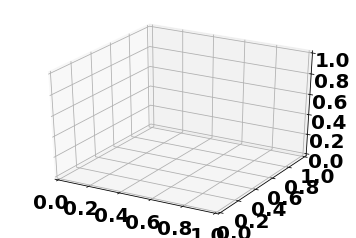

In [32]:
ax = plt.axes(projection = '3d')
def robot3D(measurements,axis):
    ax.scatter3D((measurements[0][0]), (measurements[0][1]), (measurements[0][2]),
                     c='red',s=200, label ='joints',alpha=0.5)
    ax.scatter3D((measurements[1][0]), (measurements[1][1]), (measurements[1][2]),
                     c='red',s=200, label ='joints',alpha=0.5)
    ax.scatter3D((measurements[2][0]), (measurements[2][1]), (measurements[2][2]),
                     c='red',s=200, label ='joints',alpha=0.5)
    ax.scatter3D((measurements[3][0]), (measurements[3][1]), (measurements[3][2]),
                     c='red',s=200, label ='joints',alpha=0.5)

    ax.plot3D([measurements[0][0],measurements[1][0]], 
                  [measurements[0][1],measurements[1][1]], 
                  [measurements[0][2],measurements[1][2]], 
                  'green',linewidth=9.0, label='links')

    ax.plot3D([measurements[1][0],measurements[2][0]], 
                  [measurements[1][1],measurements[2][1]], 
                  [measurements[1][2],measurements[2][2]], 
                  'green',linewidth=9.0, label='links')

    ax.plot3D([measurements[2][0],measurements[3][0]], 
                  [measurements[2][1],measurements[3][1]], 
                  [measurements[2][2],measurements[3][2]], 
                  'green',linewidth=9.0, label='links')

    ax.set_xlabel('X axis', fontsize=16, fontweight='bold', color='red')
    ax.set_ylabel('Y axis',  fontsize=16, fontweight='bold', color='green')
    ax.set_zlabel('Z axis',  fontsize=16, fontweight='bold', color='blue')
    ax.set_title('3D Manipulator of two links',fontsize = 16, fontweight = 'bold')

In [34]:
def kinematics_endeff(joint_angles):
    robot = URDF.from_xml_file('robot.urdf')
    links = [rl.name for rl in robot.links]
    kdl_kin_ee_dy = KDLKinematics(robot,'base_link','elbow2_link')
    ee_list_dy = []
    for joints in joint_angles:
        ee_list_dy.append(kdl_kin_ee_dy.forward(joints)) 
    return ee_list_dy
endEffe = kinematics_endeff(jangles_subsetbag1)
endEffe[0]

matrix([[-0.05373249, -0.90477456,  0.42248766,  0.47501354],
        [-0.11415082,  0.42589083,  0.89754476,  0.21476731],
        [-0.99200928,  0.        , -0.12616493,  0.58185657],
        [ 0.        ,  0.        ,  0.        ,  1.        ]])

In [40]:
def camera_transform(joint_angles):
    robot = URDF.from_xml_file('robot.urdf')
    links = [rl.name for rl in robot.links]
    #print(links)
    kdl_kin_cam_dy = KDLKinematics(robot,'base_link','turret_link') #maybe up to 'turretCam_link'
    print(kdl_kin_cam_dy.get_joint_names())
    cam_list_dy = []
    for joints in joint_angles:
        cam_list_dy.append(kdl_kin_cam_dy.forward(joints[:1]))
    return cam_list_dy
camHTH = camera_transform(jangles_subsetbag1)
print((camHTH[0]))

['turret']
[[ 0.42589083 -0.90477456  0.          0.254     ]
 [ 0.90477456  0.42589083  0.          0.        ]
 [ 0.          0.          1.          0.15      ]
 [ 0.          0.          0.          1.        ]]


In [41]:
def sigma_points(mu,cov,al,n,k,lam):
#computes the cholesky decomposition of matrix square root A, 
#which assumes it to be a symmetric and positive definite matrix
    chol_A = np.linalg.cholesky((n_dim+lam)*cov)
    sigma_pointx = np.zeros((7,len(mu)))
    sigma_pointx[0,:] = mu
    for i in range(3):
        sigma_pointx[i+1,:] =  mu + chol_A[:,i]
    for i in range(3):
        sigma_pointx[i+4,:] =  mu - chol_A[:,i]
    return sigma_pointx
sigma_angles = sigma_points(mu_theta,cov_theta,alpha,n_dim,kappa,lamda)
print(mu_theta,sigma_angles)


(array([ 1.12875419, -2.73882151,  2.81084536]), array([[ 1.12875419, -2.73882151,  2.81084536],
       [ 1.32240339, -2.73881529,  2.81084515],
       [ 1.12875419, -2.54484059,  2.81081303],
       [ 1.12875419, -2.73882151,  3.00449839],
       [ 0.93510499, -2.73882774,  2.81084558],
       [ 1.12875419, -2.93280243,  2.8108777 ],
       [ 1.12875419, -2.73882151,  2.61719233]]))


In [42]:
def weight_sigma(al,n,k,b,lam):
    c = n_dim + lamda
    w_mu = np.zeros((2 * n_dim + 1,1))
    w_mu[0,0] = lamda / c
    
    w_cov = np.zeros((2 * n_dim + 1,1))
    w_cov[0,0] = w_mu[0,0] + (1 - alpha**2 + beta)
    for i in range(6):
        w_mu[i+1,0] = 0.5/c
        w_cov[i+1,0] = 0.5/c
    return w_mu,w_cov
wsm, wsc = weight_sigma(alpha,n_dim,kappa,beta,lamda) 
print(wsm,wsc)

(array([[-3.        ],
       [ 0.66666667],
       [ 0.66666667],
       [ 0.66666667],
       [ 0.66666667],
       [ 0.66666667],
       [ 0.66666667]]), array([[-0.25      ],
       [ 0.66666667],
       [ 0.66666667],
       [ 0.66666667],
       [ 0.66666667],
       [ 0.66666667],
       [ 0.66666667]]))


In [43]:
#generating the new mean and covariance of the approximate Gaussian
def estimate_distri(transformedpoints,weight_mean,weight_cov,n,resh):
    mu_Keeprime = np.zeros((resh,1))
    cov_Keeprime = np.zeros((resh,resh))
    for i in range(2*(n) + 1):
        mu_Keeprime = mu_Keeprime + weight_mean[i]*transformedpoints[i,:].reshape(resh,1)
    for i in range(2*(n) + 1):
        cov_Keeprime = cov_Keeprime + weight_cov[i]*(transformedpoints[i,:].reshape(resh,1) 
                    - mu_Keeprime).dot((transformedpoints[i,:].reshape(resh,1) - mu_Keeprime).T)
    return mu_Keeprime, cov_Keeprime

In [44]:
#Transform joint angle sigma points to end-effector space
def unscented_transform():
    #Generate sigma joint angle points
    sigma_angles = sigma_points(mu_theta,cov_theta,alpha,n_dim,kappa,lamda)
    #Calculate sigma joint angle weights
    wsm, wsc = weight_sigma(alpha,n_dim,kappa,beta,lamda) 
    #propagating the points thru fk
    fbase_eeMatrices = kinematics_endeff(sigma_angles)
    fbase_poses = []
    for fbase in fbase_eeMatrices:
        fbase_poses.append(fbase[0:3,3])
        fbase_posesArr = np.array(fbase_poses)
    fbase_posesArrshaped = ((np.reshape(fbase_posesArr, (7, 3))))
    #Estimating the new Gaussian distribution of the end-effector space
    mu_xee, covmat_xee = estimate_distri(fbase_posesArrshaped,wsm, wsc,n_dim,3)
    mu_xee = mu_xee.reshape(3,)
    return mu_xee,covmat_xee,fbase_posesArrshaped
mu_xee,covmat_xee,fbase_posesArrshaped = unscented_transform()
unscented_transform()

(array([0.38954444, 0.0390855 , 0.38385033]),
 array([[0.00078954, 0.00075209, 0.00016345],
        [0.00075209, 0.00333605, 0.00030441],
        [0.00016345, 0.00030441, 0.02148513]]),
 array([[0.40136526, 0.0577403 , 0.38754897],
        [0.38749946, 0.08502132, 0.38754839],
        [0.41590883, 0.08846977, 0.36183904],
        [0.39290114, 0.03985625, 0.26343096],
        [0.40972169, 0.02830096, 0.38754954],
        [0.38497608, 0.0231112 , 0.4062233 ],
        [0.39945311, 0.05370008, 0.51315462]]))

In [46]:
def plot_ellipsoid(mu,cov,ax):
    ellipNumber = 3
    #set colour map so each ellipsoid as a unique colour
    norm = colors.Normalize(vmin=0, vmax=ellipNumber)
    cmap = cm.jet
    m = cm.ScalarMappable(norm=norm, cmap=cmap)
    #compute each and plot each ellipsoid iteratively
    for indx in range(ellipNumber):
        # your ellispsoid and center in matrix form
        A = cov
        center = mu
        # find the rotation matrix and radii of the axes
        radii, rotation = np.linalg.eig(A)
        #print(radii.shape)
        radii = np.sqrt(radii)#reduce radii by factor 0.3 
        # calculate cartesian coordinates for the ellipsoid surface
        u = np.linspace(0.0, 2.0 * np.pi, 60)
        v = np.linspace(0.0, np.pi, 60)
        x = radii[0] * np.outer(np.cos(u), np.sin(v))
        y = radii[1] * np.outer(np.sin(u), np.sin(v))
        z = radii[2] * np.outer(np.ones_like(u), np.cos(v))

        for i in range(len(x)):
            for j in range(len(x)):
                [x[i,j],y[i,j],z[i,j]] = np.dot([x[i,j],y[i,j],z[i,j]], rotation) + center

        ax.plot_surface(x, y, z,  rstride=3, cstride=3,  color=m.to_rgba(indx), linewidth=0.1, alpha=1.0, shade=True)
        ax.set_xlabel('X ', fontsize=20, fontweight='bold', color='red')
        ax.set_ylabel('Y',  fontsize=20, fontweight='bold', color='green')
        ax.set_zlabel('Z',  fontsize=20, fontweight='bold', color='blue')
#         ax.set_title('3D Manipulator of two links',fontsize = 20, fontweight = 'bold')
        plt.rcParams["font.size"] = 20
        plt.rcParams["font.weight"] = "bold"
        plt.rcParams["axes.labelweight"] = "bold"

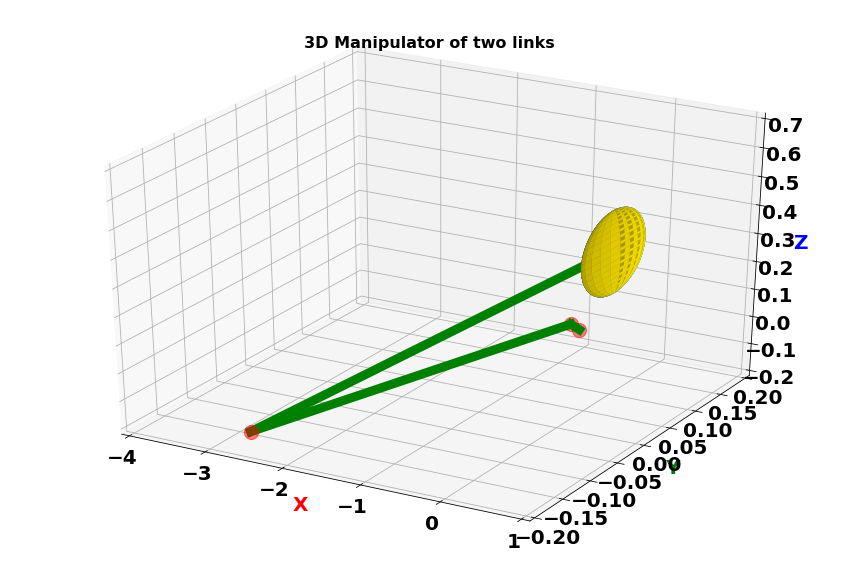

In [47]:
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111, projection='3d')
links = foward_kinematics_plot([mu_theta])
robot3D(links,ax)
plot_ellipsoid(mu_xee,covmat_xee,ax)
ax.set_xlim(-4.0, 1.0)
ax.set_ylim(-0.2, 0.2)
ax.set_zlim(-0.2, 0.7)
fig = plt.show()


In [51]:
#Camera model that projects from 3d point to image plane
def rtmapping(X_world):
    K = np.matrix([[136.848632, 0.0, 128.029255, 0],[0.0, 138.204089, 86.254287, 0],[ 0.0, 0.0, 1.0, 0.0]]) 
    H = camHTH[0]
    P = K * H 
    x_im = P.dot(np.concatenate((X_world, np.array([1])), axis=0))
    return x_im

In [52]:
def cameramodel_UT():
    mu_xee, covmat_xee,fbase_posesArrshaped = unscented_transform()
    sigma_xee = sigma_points(mu_xee,covmat_xee,alpha, n_dim, kappa,lamda)
    #Assign weights to the sigma points
    wsm, wsc = weight_sigma(alpha,n_dim,kappa,beta,lamda) 
    
    image_eeHomog = np.ones((sigma_xee.shape[0],3))
    #Propagating sigma points through camera model
    for i in range(sigma_xee.shape[0]):
        #a = ((sigma_xee[i,:]))#, np.array([1])), axis=0)
        image_eeHomog[i,:] = rtmapping(sigma_xee[i,:])
    print(sigma_xee.shape)
    return image_eeHomog      
image_eeHomog = cameramodel_UT()
image_eeHomog

(7, 3)


array([[120.97221164,  97.05746334,   0.53385033],
       [120.16538869, 101.89919386,   0.53888815],
       [115.80613328,  99.88347418,   0.53636654],
       [137.20829003, 107.99583337,   0.66066571],
       [121.77903459,  92.21573283,   0.52881252],
       [126.13829   ,  94.23145251,   0.53133413],
       [104.73613325,  86.11909332,   0.40703495]])

In [53]:
def endEffecImage2d(ee_ImaHomo):
    for i in range(len(ee_ImaHomo )):
        x= ee_ImaHomo[:,0]/ee_ImaHomo[:,2]
        y= ee_ImaHomo[:,1]/ee_ImaHomo[:,2]
        xx,yy = x.reshape(len(ee_ImaHomo),1),y.reshape(len(ee_ImaHomo),1)
    return np.hstack((xx,yy))
end_effe2D = endEffecImage2d(image_eeHomog)
end_effe2D

array([[226.60323349, 181.80650523],
       [222.98762588, 189.09154763],
       [215.90857265, 186.22241958],
       [207.68186955, 163.4651709 ],
       [230.2877304 , 174.38265865],
       [237.39918631, 177.34876658],
       [257.31483753, 211.57665285]])

In [55]:
#predicted mean and cov(uncertain end eff pose) in the image plane
wsm, wsc = weight_sigma(alpha,n_dim,kappa,beta,lamda) 
predictedObservat_mu,predictedUncer_cov = estimate_distri(endEffecImage2d(image_eeHomog),wsm, wsc,n_dim,2)

In [56]:
#sensor data
camera_dylist = []
for i in range(len(vicobags_dyna)):
    robot_dy = np.load(data_path+'robot_dynaPosArr%d.npy'%i)
    camera_dylist.append(robot_dy)
cam_dataXYZ = camera_dylist[1]
print(cam_dataXYZ[0])

[0.09550175 0.04238624 0.37334079]


In [57]:
sensordata_z = rtmapping(cam_dataXYZ[0])
sensordata_in2d = endEffecImage2d(sensordata_z)
sensordata_in2d.reshape(2,1)

m_noiseQ = 0.05 *np.eye(2,dtype=float)

In [58]:
def plot2Dellipse(mu,cov,point,xlimit,ylimit,edgecolor,color):
    a = np.squeeze(np.asarray(point))
    #b = np.squeeze(np.asarray(Sampled_point))
    x0,y0 = a
    #x1,y1 = b
    #mu= predicted_mu
    #cov = predicted_cov
    lambda_, v = np.linalg.eig(cov)
    lambda_ = np.sqrt(lambda_)
    from matplotlib.patches import Ellipse
    import matplotlib.pyplot as plt
    ax = plt.subplot(111, aspect='equal')
    for j in range(1, 4):
        ell = Ellipse(xy=(mu[0], mu[1]),width=lambda_[0]*j*2, height=lambda_[1]*j*2,
                          angle=np.rad2deg(np.arccos(v[0, 0])),linewidth=4,edgecolor=edgecolor)
        ell.set_facecolor('none')
        ax.add_artist(ell)
    plt.scatter(x0, y0,c=color)
    #plt.scatter(x1, y1,c='blue')
    plt.xlim(xlimit)
    plt.ylim(ylimit)
    plt.xlabel('x-axis', fontsize=10)
    plt.ylabel('y-axis', fontsize=10)
    

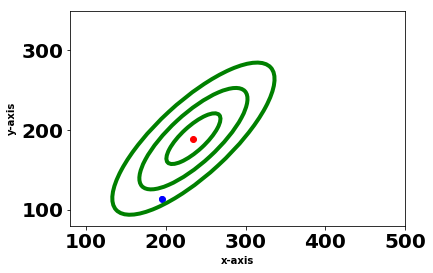

In [59]:
plot2Dellipse(predictedObservat_mu,predictedUncer_cov,predictedObservat_mu, (80,500), (80,350), "green","red")
plot2Dellipse(sensordata_in2d.reshape(2,1),m_noiseQ,sensordata_in2d.reshape(2,1), (80,500), (80,350),"blue","blue")
plt.show()

In [61]:
mu_xee, covmat_xee,fbase_posesArrshaped = unscented_transform() 
sigma_xee = sigma_points(mu_xee,covmat_xee,alpha, n_dim, kappa,lamda)

#cross covariance between X and Z
cross_cov = np.zeros((3,2))
for i in range(2*(3) + 1):
        cross_cov = cross_cov + wsc[i] *(sigma_xee[i,:].reshape(3,1)
                                     - mu_xee.reshape(3,1)) *(end_effe2D[i,:].reshape(2,1) 
                                                              - predictedObservat_mu).T
        
        
#Compute Kalman gain and the final prediction mean and covariance
kalman_gain = cross_cov.dot(np.linalg.inv(predictedUncer_cov))

# actual_mu_meas is T to align (2,1) dim, mu_xee is reshaped from 3, to 3,1
final_predic_mu = mu_xee.reshape(3,1) + kalman_gain.dot(sensordata_in2d.reshape(2,1) - predictedObservat_mu)
mu_final = np.squeeze(np.asarray(final_predic_mu))
final_predic_cov = covmat_xee - kalman_gain.dot(predictedUncer_cov).dot(kalman_gain.T)

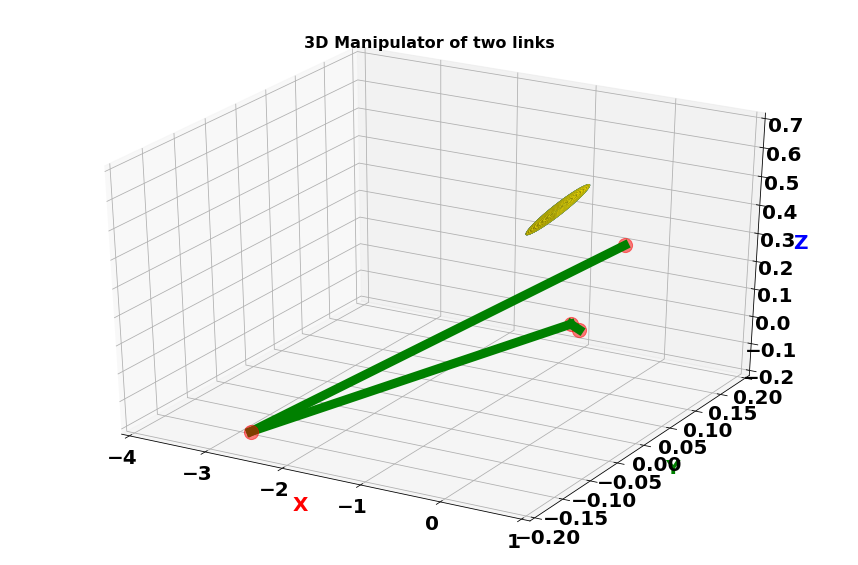

In [70]:
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111, projection='3d')
links = foward_kinematics_plot([mu_theta])
robot3D(links,ax)
plot_ellipsoid(mu_final,final_predic_cov,ax)
ax.set_xlim(-4.0, 1.0)
ax.set_ylim(-0.2, 0.2)
ax.set_zlim(-0.2, 0.7)
fig = plt.show()


In [71]:
#vicon_dylist = []
# for i in range(len(vicobags_dyna)):     
#     vicon_dy = np.load(data_path+'vicon_dynaPosArr%d.npy'%i)
#     vicon_dylist.append(vicon_dy)    
# vicon_endeff_subsetbag1 = vicon_dylist[1]

# #projecting it to the image plane
# ee_poseVicon = rtmapping(vicon_endeff_subsetbag1[0])
# #reuse the func for converting to 2D image plane
# actual_mu_meas = endEffecImage2d(ee_poseVicon)
# actual_point = actual_mu_meas.reshape(2,1)
# nDmeanTo_1d = np.squeeze(np.asarray(actual_point))
